In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image, ImageOps
import os
import json
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
import zipfile
import os

zip_file_path = r"C:\Users\Hussein\Desktop\compvis proj\annotated_images.zip"
extract_path = r"C:\Users\Hussein\Desktop\compvis proj\annotated_images_file"

# Extract the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")


Dataset extracted to C:\Users\Hussein\Desktop\compvis proj\annotated_images_file


In [8]:
import json

annotations_path = r"C:\Users\Hussein\Desktop\compvis proj\annotations_map.json"

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

print(f"Number of annotations: {len(annotations)}")


Number of annotations: 8


In [10]:
import os
import json
import shutil

# Paths
annotations_path = r"C:\Users\Hussein\Desktop\compvis proj\annotations_map.json"
images_dir = r"C:\Users\Hussein\Desktop\compvis proj\annotated_images._file"
output_dir = r"C:\Users\Hussein\Desktop\compvis proj\organized_images"

# Class merging rules
merge_map = {
    1: 1,  # Head with left hand -> Head
    2: 1,  # Head with right hand -> Head
    3: 2,  # Body with left hand -> Body
    4: 2,  # Body with right hand -> Body
    5: 3,  # Block with left hand -> Block
    6: 3,  # Block with right hand -> Block
    7: None,  # Miss with left hand -> Remove
    8: None   # Miss with right hand -> Remove
}

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Update annotations based on merge_map
updated_annotations = {}
for image, cls in annotations.items():
    new_cls = merge_map.get(cls)
    if new_cls is not None:  # Keep if not marked for removal
        updated_annotations[image] = new_cls

# Save updated annotations
updated_annotations_path = r"C:\Users\Hussein\Desktop\compvis proj\updated_annotations_map.json"
with open(updated_annotations_path, 'w') as f:
    json.dump(updated_annotations, f, indent=4)

print(f"Updated annotations saved to {updated_annotations_path}")

# Create directories for merged classes
os.makedirs(output_dir, exist_ok=True)
for cls in set(updated_annotations.values()):
    cls_dir = os.path.join(output_dir, str(cls))
    os.makedirs(cls_dir, exist_ok=True)

# Move images to corresponding directories
for image, cls in updated_annotations.items():
    src_path = os.path.join(images_dir, image)
    dest_dir = os.path.join(output_dir, str(cls))
    dest_path = os.path.join(dest_dir, image)

    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
    else:
        print(f"Image {image} not found in {images_dir}")

print("Class merging and image reorganization complete.")


Updated annotations saved to C:\Users\Hussein\Desktop\compvis proj\updated_annotations_map.json
Image Head with left hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Image Head with right hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Image Body with left hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Image Body with right hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Image Block with left hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Image Block with right hand not found in C:\Users\Hussein\Desktop\compvis proj\annotated_images._file
Class merging and image reorganization complete.


In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

# Paths
dataset_dir = r"C:\Users\Hussein\Desktop\compvis proj\organized_images"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Compute lengths
total_len = len(full_dataset)
train_len = int(train_ratio * total_len)
val_len = int(val_ratio * total_len)
test_len = total_len - train_len - val_len

# Perform the splits
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify split sizes
print(f"Total Samples: {total_len}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total Samples: 5115
Train: 3580, Val: 1023, Test: 512


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F

# Define the PyTorch model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Conv2D(16, 3, padding='same')
            nn.ReLU(),
            nn.MaxPool2d(2),                            # MaxPooling2D
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Conv2D(32, 3, padding='same')
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Conv2D(64, 3, padding='same')
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * (img_height // 8) * (img_width // 8), 128),  
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

img_height = 224  
img_width = 224   
num_classes = len(full_dataset.classes)  

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)


SimpleCNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=3, bias=True)
  )
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [14]:
from tqdm import tqdm

# Training loop with progress bar
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())  # Update progress bar with loss

    print(f"Training Loss: {running_loss / len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_bar = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_bar.set_postfix(loss=loss.item())  # Update progress bar with loss

    val_accuracy = correct / total * 100
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")


Epoch 1/20


Training Loss: 0.6462


Validation Loss: 0.6298, Accuracy: 75.46%
Epoch 2/20


Training Loss: 0.4863


Validation Loss: 0.5906, Accuracy: 78.69%
Epoch 3/20


Training Loss: 0.3060


Validation Loss: 0.7009, Accuracy: 80.06%
Epoch 4/20


Training Loss: 0.1656


Validation Loss: 0.8567, Accuracy: 80.35%
Epoch 5/20


Training Loss: 0.0646


Validation Loss: 1.0379, Accuracy: 80.25%
Epoch 6/20


Training Loss: 0.0355


Validation Loss: 1.1778, Accuracy: 80.84%
Epoch 7/20


Training Loss: 0.0108


Validation Loss: 1.3845, Accuracy: 80.94%
Epoch 8/20


Training Loss: 0.0015


Validation Loss: 1.4361, Accuracy: 81.33%
Epoch 9/20


Training Loss: 0.0004


Validation Loss: 1.5124, Accuracy: 81.33%
Epoch 10/20


Training Loss: 0.0002


Validation Loss: 1.5572, Accuracy: 81.23%
Epoch 11/20


Training Loss: 0.0002


Validation Loss: 1.6124, Accuracy: 81.43%
Epoch 12/20


Training Loss: 0.0001


Validation Loss: 1.6478, Accuracy: 81.52%
Epoch 13/20


Training Loss: 0.0001


Validation Loss: 1.6779, Accuracy: 81.82%
Epoch 14/20


Training Loss: 0.0001


Validation Loss: 1.7063, Accuracy: 81.72%
Epoch 15/20


Training Loss: 0.0001


Validation Loss: 1.7263, Accuracy: 81.62%
Epoch 16/20


Training Loss: 0.0001


Validation Loss: 1.7478, Accuracy: 81.72%
Epoch 17/20


Training Loss: 0.0000


Validation Loss: 1.7652, Accuracy: 81.72%
Epoch 18/20


Training Loss: 0.0000


Validation Loss: 1.7800, Accuracy: 81.62%
Epoch 19/20


Training Loss: 0.0000


Validation Loss: 1.7988, Accuracy: 81.62%
Epoch 20/20


Training Loss: 0.0000


Validation Loss: 1.8183, Accuracy: 81.82%


In [15]:
model_save_path = r"C:\Users\Hussein\Desktop\compvis proj\punch_classifier_entire.pth"

# Save the entire model
torch.save(model, model_save_path)
print(f"Entire model saved successfully at {model_save_path}")

Entire model saved successfully at C:\Users\Hussein\Desktop\compvis proj\punch_classifier_entire.pth


Testing: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]



Test Accuracy: 81.25%

Confusion Matrix:
[[327  10  29]
 [ 11  25   5]
 [ 41   0  64]]

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.89      0.88       366
           2       0.71      0.61      0.66        41
           3       0.65      0.61      0.63       105

    accuracy                           0.81       512
   macro avg       0.74      0.70      0.72       512
weighted avg       0.81      0.81      0.81       512



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.461769].


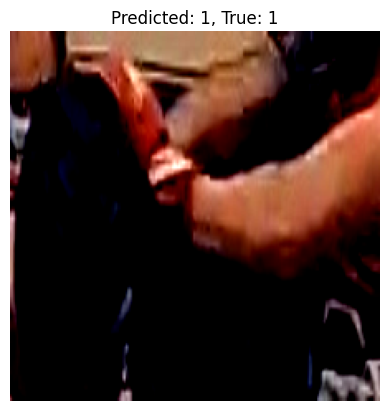

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7241396].


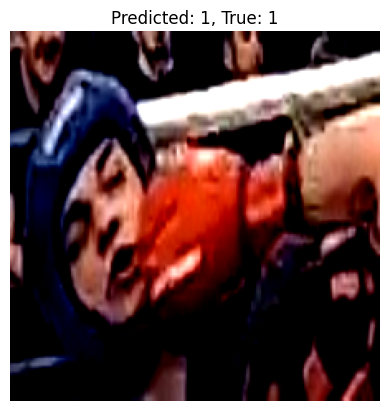

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.2562718].


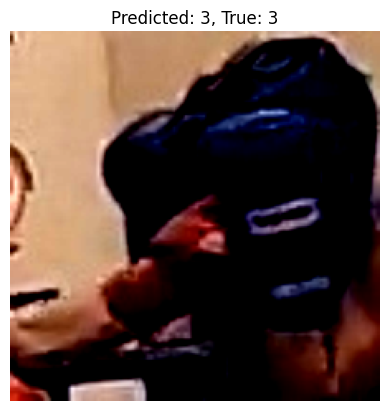

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.7154248].


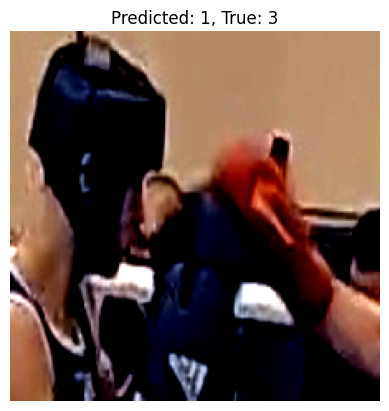

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.5217056].


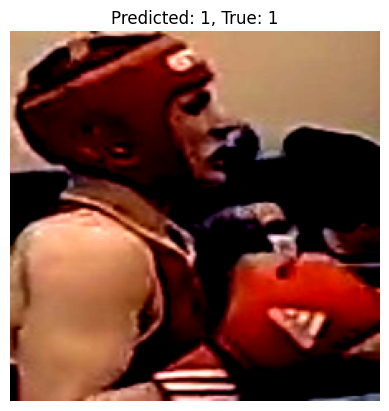

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Initialize metrics
correct = 0
total = 0
all_preds = []
all_labels = []

# Testing the model
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Predicted classes

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Collect predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute test accuracy
test_accuracy = correct / total * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Visualize a few predictions
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display test images with predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show first 5 images and their predictions
for i in range(5):
    imshow(images[i].cpu(), f"Predicted: {full_dataset.classes[preds[i]]}, True: {full_dataset.classes[labels[i]]}")
